# Getting started exercise for RSA3.0

## Introduction

In these three exercises you will get an introduction to the functionality of the new pyRSA-toolbox for inferring the underlying model representation based on measured data. Generally we assume that there is a true underlying representation, which is captured by our model. The measurement process like fMRI will lead to a distorted view of that representation, which we may or may not include into our analysis as an explicit measurement model.  

For illustration these exercises use simulated RDMs from the paper "Inferring brain-computational mechanisms with models of activity measurements" by Kriegeskorte & Diedrichsen (2016). Ground truth RDMs are here simulated based on the layers of Alexnet--the deep neural network model, which sparked the interest in deep learning. Simulated data rdms were generated as follows: First, voxel responses were generated by randomly selecting locations within the layer and modelling their response as a local average of the feature values. Then, noise was added to those voxel responses and RDMs were computed from these noisy responses. As model predictions to compare to, we use noise-free RDMs generated for each layer, by applying different amounts of smoothing and averaging to the layer representation. 

Our overall aim in this setting is to infer which representation the data rdms were based on, i.e. which layer was used for generating the data. Towards this aim we will make three steps:

In *Exercise 1*, we will load the data, convert them into the formats used in the toolbox and have a first exploratory look at the data.

In *Exercise 2*, we will compare the RDMs based on the undistorted representations to the simulated data RDMs. This is the classical and simplest approach and already allows us to perform model comparisons and the general evaluation of model-RDMs. This approach uses *fixed models*, i.e. each model predicts a single fixed RDM. We will see that this does not allow us to correctly infer the underlying representation though, because the measurement process distorts the RDMs too much.

In *Exercise 3*, we will apply *flexible models*. This means that each model predicts a distribution of RDMs. In the present context this means that the model is flexible in which measurement model is applied to explain the data. To evaluate such flexible models additional cross-validation is necessary, which we also discuss in this exercise.

## Exercise 1: Data and RDM handling

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pyrsa

### Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format.

For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions.

In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])

These steps are not specific to the toolbox, but to the format the RDMs were originally saved in.
To load other data, simply transform them such that they are numpy arrays of either the whole RDM or vector format of the upper triangular part of the matrix.

### Store the model RDMs as a pyRSA object
We place the RDMs in a pyRSA object which can contain additional descriptors for the RDMs and the experimental conditions.
Here we label each RDM with the name of the brain-computational model (AlexNet layer) and the name of the measurement model.

In [19]:
model_rdms = pyrsa.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

The variable model_rdms is now a custom object, which contains all the RDMs from the .mat file with the additional information.
It also has a few methods for forming subsets of the data, saving and loading, etc.

### Show the RDMs from AlexNet layer conv1

As a simple example, select the RDMs that correspond to the first convolutional layer. These can then be plotted using the function pyrsa.vis.show_rdm.

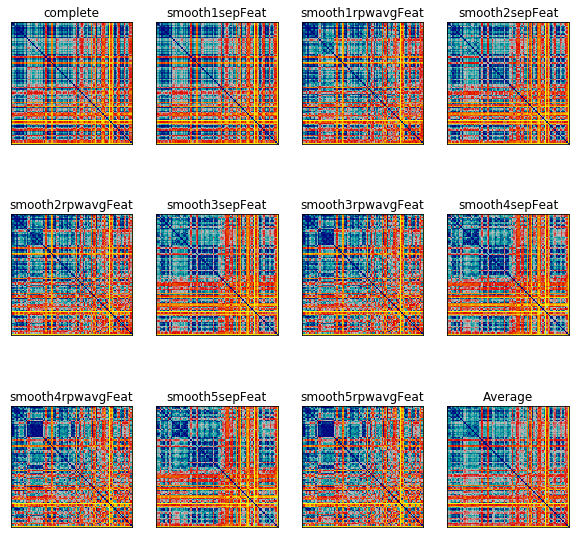

In [22]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
plt.figure(figsize=(10,10))
pyrsa.vis.show_rdm(conv1_rdms, do_rank_transform=True, rdm_descriptor='measurement_model')

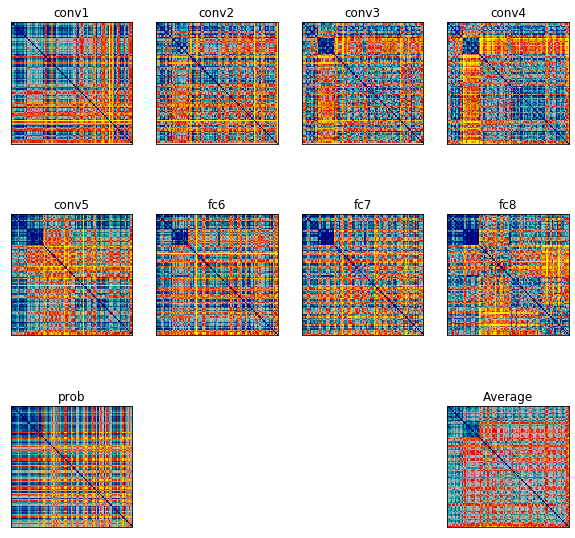

In [23]:
conv1_rdms = model_rdms.subset('measurement_model','complete')
plt.figure(figsize=(10,10))
pyrsa.vis.show_rdm(conv1_rdms, do_rank_transform=True, rdm_descriptor='brain_computational_model')

These are the RDMs which were generated from convolutional layer 1 by different measurement models. Each RDM is labeled with the name of the measurement model. Also in the lower right corner the average RDM is plotted.

### Print information about a set of RDMs
The pyRSA objects can simply be passed to the print function to obtain a short description of their content.

### Questions

Of course, you can also show all RDMs or select any other subset. Have a look at the different RDMs!

How many RDMs are there for each layer?

Generate a plot which shows all RDMs with the 'complete' measurement model.

How different do the different measurement models look to you and how different do the different layers look?


## Exercise 2: Fixed model inference
### Load data RDMs
Here we use simulated data to demonstrate RSA inference.
Since we know the true data-generating model in each case, we can tell when inference fails or succeeds.

For each data RDM, we obtain the name of the underlying Layer, a full width at half maximum (FWHM) value and a noise standard deviation. The FWHM value specifies the spatial range the simulated voxels average over. The noise standard deviation specifies how much noise was added to the voxel responses.

In [37]:
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')


### Choose the data RDMs for inference

Here we choose which data RDMs we use for the exercise. You can change the representation, the noise level and the amount of averaging by chaning the index values at the beginning.

We then convert the chosen data RDMs into an pyrsa RDMs object and display them as we did for the model RDMs.

The chosen ground truth model is:
fc8
with noise level:
3.0
with averaging width (full width at half magnitude):
2.0


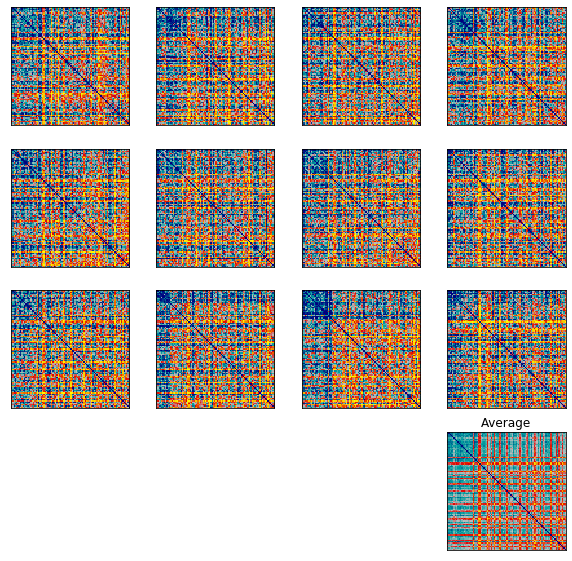

In [72]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 7 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 1 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = pyrsa.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

plt.figure(figsize=(10,10))
pyrsa.vis.show_rdm(rdms_data, do_rank_transform=True)

### Define fixed models
An "RDM model" is a pyRSA object that can predict a data RDM.
For example, a flexible RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

Models are generated by first choosing the RDM, in this case the one with the right "brain_computational_model" and the "measurement_model" "complete", which corresponds to no distortions added. This object is then passed to the function `pyrsa.model.ModelFixed`, which generates a fixed RDM model. These RDM models are then collected in the list `models`. 

In [73]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = pyrsa.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Compare model RDMs to measured RDMs
Evaluate models naively, i.e. simply compute the average correlation to the data RDMs.

In [75]:
pyrsa.inference.eval_fixed?

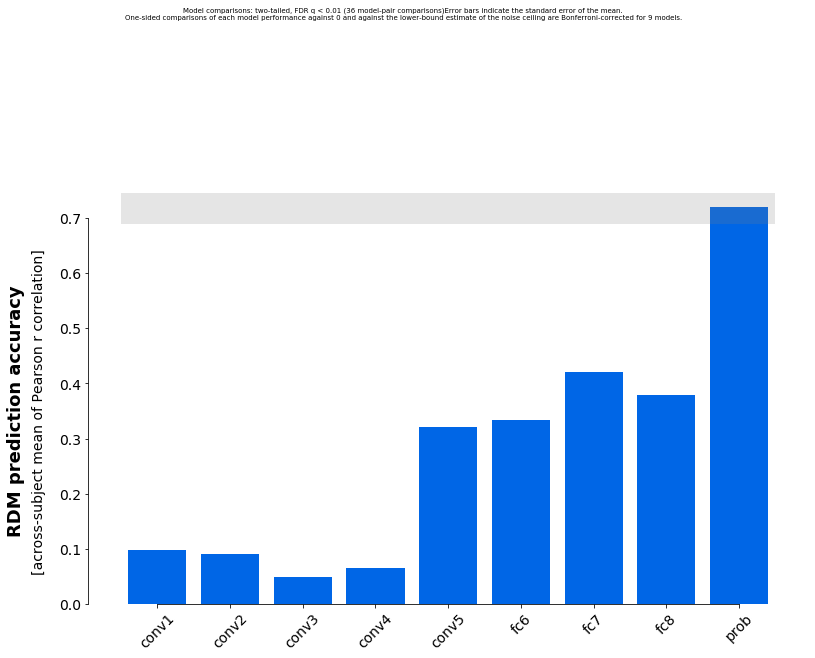

In [77]:
results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_1)

#results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='spearman')
#pyrsa.vis.plot_model_comparison(results_1)

#results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='tau-a')
#pyrsa.vis.plot_model_comparison(results_1)

#results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='rho-a')
#pyrsa.vis.plot_model_comparison(results_1)

In these plots the models do not have errorbars as we did not run any estimate of the variablitiy.
The upper bound of the noise ceiling is computed by finding the RDM with the highest possible average similarity to the measured RDMs. This is not 1 because the RDMs for different subjects or measurements differ. The lower bound of the noise ceiling is a leave one out crossvalidation of this averaging procedure, i.e. we find the RDM to perform optimally on all but one of the RDMs and evaluate this average RDM on the left-out RDM. Each RDM is left out once and the correlations are averaged.

### Bootstrapping
To perform statistical comparisons and estimate how uncertain we should be about the models' performance, we can perform bootstrapping:

In each plot the errobars correspond to +/- one SEM based on the bootrap samples.
The lines above the plot show which pairwise comparisons are significant.

#### Model comparison by bootstrapping the subjects
We can bootstrap resample the subjects, which estimates how variable the model performances would be if we repeted the experiment with the same stimuli but new subjects from the same population. Based on that uncertainty estimate, we can statistically compare model performances. We would like to take the many pairwise model comparisons into account in performing inference. We have a choice: We can either control the family wise error rate (FWER) or the false discovery rate (FDR). Here we use a Bonferroni correction for FWER and the Benjamini-Hochberg procedure for FDR.

100%|██████████| 1000/1000 [00:16<00:00, 60.00it/s]


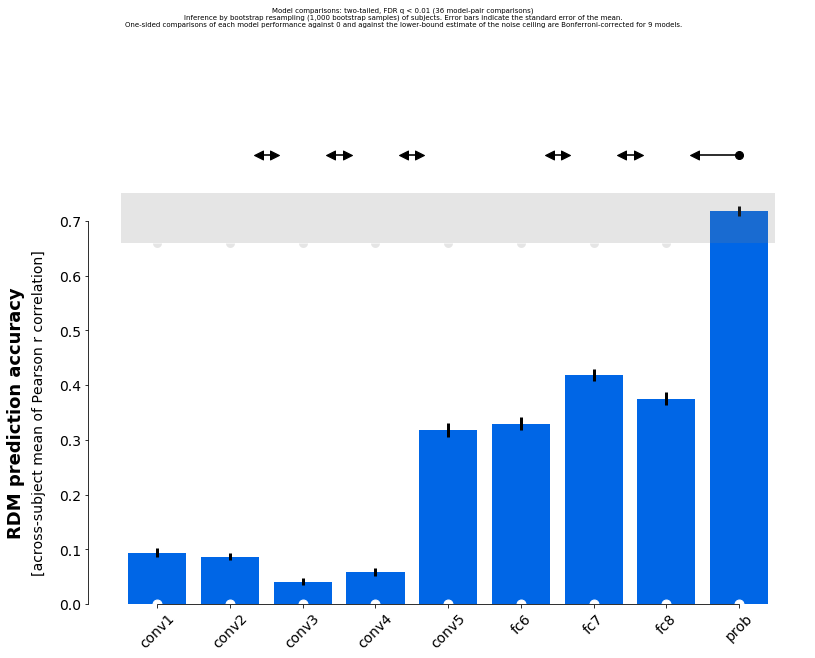

In [78]:
results_2a = pyrsa.inference.eval_bootstrap_rdm(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2a)

#### Model comparison by bootstrapping the stimuli
We can alternatively bootstrap resample the stimuli to estimate how much model performance would vary if we repeated the experiment with the same subjects using a new sample of stimuli from the same population. 

100%|██████████| 1000/1000 [00:32<00:00, 30.87it/s]


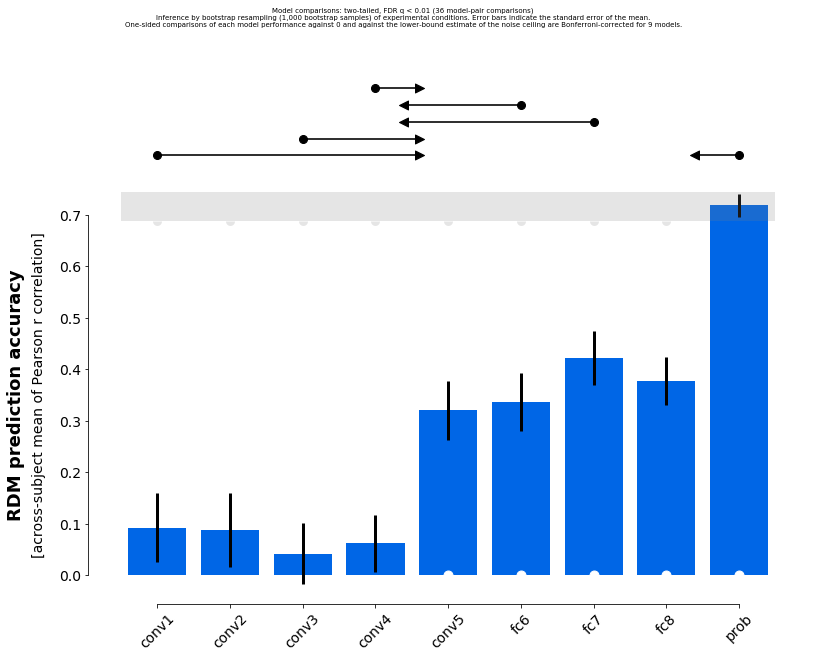

In [79]:
results_2b = pyrsa.inference.eval_bootstrap_pattern(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2b)

#### Model comparison by bootstrapping both stimuli and subjects
Finally, we can bootstrap resample both stimuli and subjects to estimate how variable the model performances would be if we repeated the experiment with new subjects and new stimuli from their respective populations:

100%|██████████| 1000/1000 [00:25<00:00, 38.50it/s]


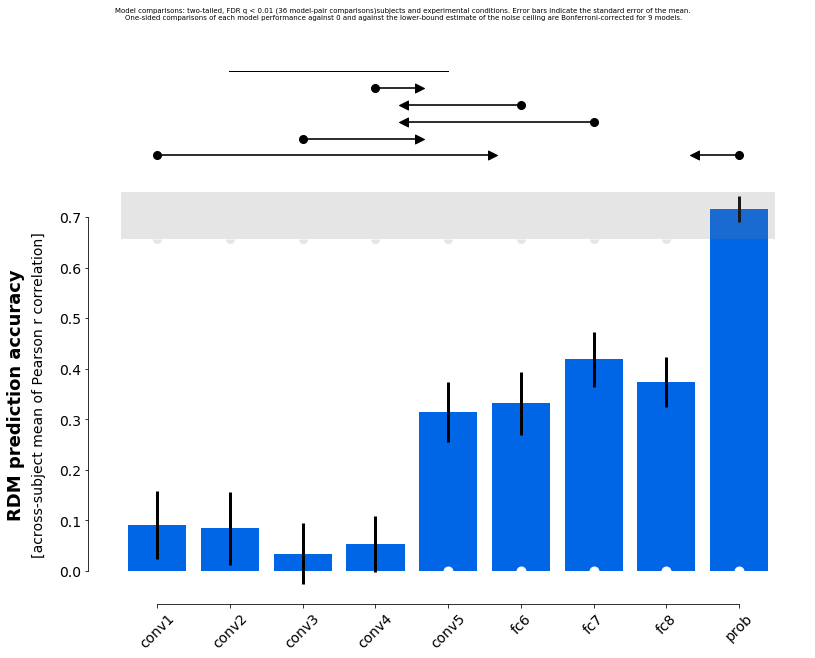

In [80]:
results_2c = pyrsa.inference.eval_bootstrap(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2c)

### Questions
Does the right model win? And do the mean estimates from bootstrapping differ from the evaluations over the whole dataset?

Compare the results for the different bootstrapping methods. Which method leads to the widest confidence intervals, which one to the smallest?

## Exercise 3: Crossvalidation for flexible models
### Defining flexible models
Here we use a type of flexible model called a *selection model*. This type of model specifies that the true RDM is one from a list of RDMs. To evaluate flexible models, they have to be fitted to data, i.e. we need to provide some data, which can be used to adjust the RDM-prediction of the model. For a selection model, the fitting process simply selects the RDM that performs best on the training data. The model will perform better on this data than on independent data. An unbiased performance estimate therefore requires independent test data. Crossvalidation is a data-efficient way of obtaining an unbiased performance estimate.

We first have to generate the selection models. This process is the same as for fixed models, but uses `pyrsa.model.ModelSelect` and passes multiple RDMs instead of a single one:

In [81]:
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(pyrsa.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Crossvalidation
As a first step, we split our data into training and test sets, which should not share either subjects or stimuli. To do so, we split each dimension into k groups and leave one of these groups out as a testset and use all others as training data. Models choose their parameters to maximize performance on the training set and are evaluated on the test set. Additionally a so-called *ceil set* is created, which contains the data from the training subjects for the test stimuli, which is necessary for calculating a noise ceiling.

The variables `k_pattern` and `k_rdm` specify how many folds should be formed over stimuli and subjects, respectively.

In [84]:
train_set, test_set, ceil_set = pyrsa.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)

KeyError: None

With these sets we can now evaluate our models, as we did without crossvalidaton, and plot the results. The performance estimates will be averaged across folds and we obtain a single performance estimate without errorbars. The variability over cross-validation folds are not indicative of the variability across independent datasets. Although training and test data are independent of each other in each fold, performance estimates are not independent across folds of crossvalidation.

In [83]:
results_3_cv = pyrsa.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_cv)

NameError: name 'train_set' is not defined

### Bootstrapped Crossvalidation

We can perform bootstrapping around the crossvalidation to get uncertainty estimates for the evaluation and for model comparison.

In [ ]:
results_3_full = pyrsa.inference.bootstrap_crossval(models_flex, rdms_data, k_pattern=4, k_rdm=2, method='corr', N=100)
# plot results
pyrsa.vis.plot_model_comparison(results_3_full)

### Questions

Does the right model win?

Try some different settings for the crossvalidation: How do the results change when you make the training and test sets larger or smaller?


In [ ]:
#[your code here]